In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

## Data

Info about this data set: https://fred.stlouisfed.org/series/IPN31152N


Units:  Index 2012=100, Not Seasonally Adjusted

Frequency:  Monthly

The industrial production (IP) index measures the real output of all relevant establishments located in the United States, regardless of their ownership, but not those located in U.S. territories.

NAICS = 31152

Source Code: IP.N31152.N

Suggested Citation:
Board of Governors of the Federal Reserve System (US), Industrial Production: Nondurable Goods: Ice cream and frozen dessert [IPN31152N], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/IPN31152N, November 16, 2019.

# Project Tasks

**TASK: Read in the data set "Frozen_Dessert_Production.csv" from the Data folder. Figure out how to set the date to a datetime index columns**

In [2]:
# CODE HERE

In [3]:
df = pd.read_csv('../DATA/Frozen_Dessert_Production.csv',parse_dates=True, index_col='DATE')

In [4]:
df.head()

,IPN31152N
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


**Task: Change the column name to Production**

In [5]:
#CODE HERE
df.columns = ['Production']

In [6]:
df.head()

,Production
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


**TASK: Plot out the time series**

<Axes: xlabel='DATE'>

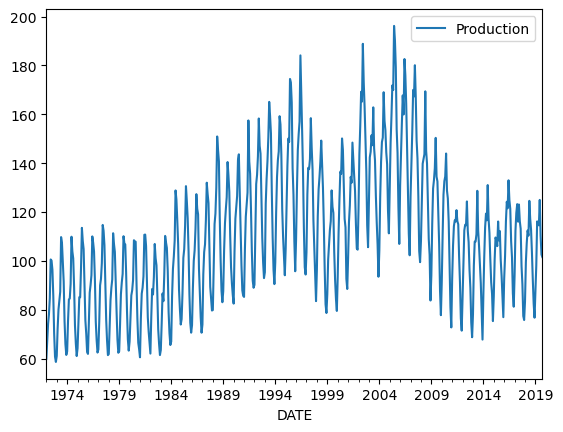

In [7]:
#CODE HERE
df.plot()

## Train Test Split

**TASK: Figure out the length of the data set**

In [8]:
#CODE HERE
len(df)

573

**TASK: Split the data into a train/test split where the test set is the last 24 months of data.**

In [9]:
#CODE HERE

In [10]:
test_size = 24
test_ind = len(df) - 24
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

## Scale Data

**TASK: Use a MinMaxScaler to scale the train and test sets into scaled versions.**

In [11]:
# CODE HERE
from sklearn.preprocessing import MinMaxScaler

In [12]:
scaler = MinMaxScaler()

In [13]:
scaler.fit(train)

MinMaxScaler()

In [14]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

# Time Series Generator

**TASK: Create a TimeSeriesGenerator object based off the scaled_train data. The batch length is up to you, but at a minimum it should be at least 18 to capture a full year seasonality.**

In [15]:
#CODE HERE
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator 

In [16]:
length = 18
generator = TimeseriesGenerator(scaled_train,scaled_train,length = length, batch_size=1)

### Create the Model

**TASK: Create a Keras Sequential Model with as many LSTM units you want and a final Dense Layer.**

In [17]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [18]:
model = Sequential()

model.add(LSTM(units = 100, input_shape = (length, 1)))
model.add(Dense(1))

model.compile(optimizer='adam',loss='mse')

C:\Users\kuban\anaconda3\envs\DataScience\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 100)                 │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 40,901 (159.77 KB)

 Trainable params: 40,901 (159.77 KB)

 Non-trainable params: 0 (0.00 B)

**TASK: Create a generator for the scaled test/validation set. NOTE: Double check that your batch length makes sense for the size of the test set as mentioned in the RNN Time Series video.**

In [20]:
# CODE HERE
validation_generator = TimeseriesGenerator(scaled_test, scaled_test, length=length, batch_size=1)

**TASK: Create an EarlyStopping callback based on val_loss.**

In [21]:
#CODE HERE
from tensorflow.keras.callbacks import EarlyStopping

In [22]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 2)

**TASK: Fit the model to the generator, let the EarlyStopping dictate the amount of epochs, so feel free to set the parameter high.**

In [23]:
# CODE HERE
model.fit(generator, epochs = 20, validation_data=validation_generator, callbacks=[early_stop])

Epoch 1/20
  5/531 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0854 

C:\Users\kuban\anaconda3\envs\DataScience\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


531/531 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 0.0303 - val_loss: 0.0019
Epoch 2/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0051 - val_loss: 0.0069
Epoch 3/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0039 - val_loss: 0.0037


**TASK: Plot the history of the loss that occured during training.**

In [24]:
# CODE HERE
loss = pd.DataFrame(model.history.history)

<Axes: >

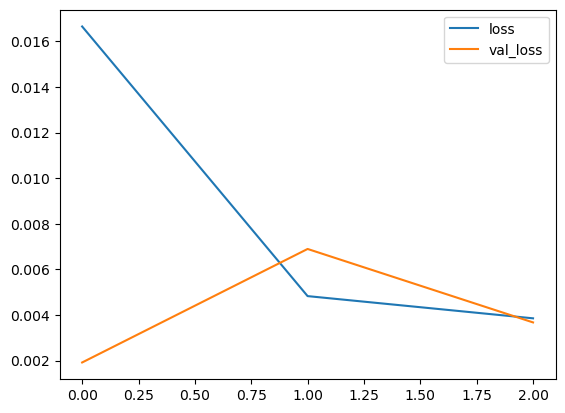

In [25]:
loss.plot()

## Evaluate on Test Data

**TASK: Forecast predictions for your test data range (the last 12 months of the entire dataset). Remember to inverse your scaling transformations. Your final result should be a DataFrame with two columns, the true test values and the predictions.**

In [26]:
# CODE HERE

In [27]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, 1))

for i in range(len(test)):
    
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


In [28]:
true_predictions = scaler.inverse_transform(test_predictions)

In [29]:
test.loc[:,'Predictions'] = true_predictions

C:\Users\kuban\AppData\Local\Temp\ipykernel_3776\1331392772.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:,'Predictions'] = true_predictions


**TASK: Plot your predictions versus the True test values. (Your plot may look different than ours).**

<Axes: xlabel='DATE'>

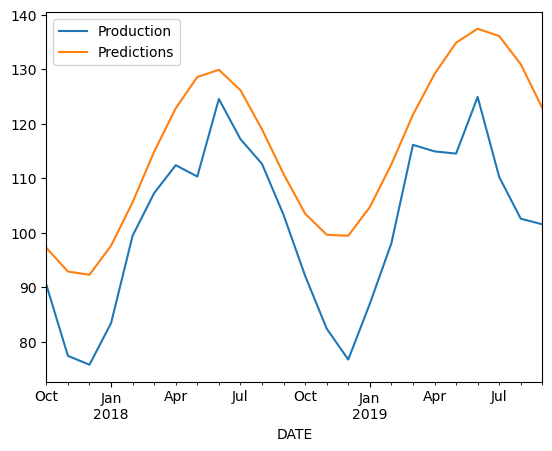

In [30]:
# CODE HERE
test.plot()

**TASK: Calculate your RMSE.**

In [31]:
#CODE HERE

In [32]:
from sklearn.metrics import mean_squared_error

In [33]:
mean_squared_error(test['Predictions'], test['Production'])

237.60822922875198

In [34]:
np.sqrt(mean_squared_error(test['Predictions'], test['Production']))

15.414546027332495